# Analysis of optimization results

This notebook reproduces Figure 3 from raw data, and shows the raw compliance numbers from the Appendix Table.

## Setup

In [0]:
# Install dependencies with pip. Only run this once.
! pip install -q tf-nightly git+https://github.com/google-research/neural-structural-optimization.git

## Get and inspect the raw data

It's stored in a 188 MB netCDF file (version 3) in cloud storage.

The data is most easily loaded in [xarray](http://xarray.pydata.org/en/stable/), which we'll use along with the standard scientific Python stack (numpy, pandas, seaborn, matplotlib) for analysis.


In [0]:
# Copy the data for analysis
! gsutil cp gs://neural-structural-optimization-public/all_losses.nc .

Copying gs://neural-structural-optimization-public/all_losses.nc...
| [1 files][188.0 MiB/188.0 MiB]                                                
Operation completed over 1 objects/188.0 MiB.                                    


In [0]:
import xarray
import seaborn
import numpy as np
import pandas
import matplotlib.pyplot as plt
from neural_structural_optimization import problems

In [0]:
ds = xarray.open_dataset('all_losses.nc').load()

In [0]:
ds

<xarray.Dataset>
Dimensions:       (method_name: 4, problem_name: 116, seed: 102, step: 1039)
Coordinates:
  * step          (step) int32 0 1 2 3 4 5 6 ... 1033 1034 1035 1036 1037 1038
  * problem_name  (problem_name) object 'anchored_suspended_bridge_128x128_0.1' ... 'two_level_bridge_64x64_0.2'
    elapsed_time  (problem_name, method_name, seed) float64 nan ... 147.8
    design_area   (problem_name) float64 1.0 1.0 1.0 1.0 ... 0.4375 1.0 1.0 1.0
    width         (problem_name) int32 128 256 256 64 192 ... 256 64 128 256 64
    density       (problem_name) float64 0.1 0.05 0.075 0.15 ... 0.16 0.12 0.2
    height        (problem_name) int32 128 256 256 64 64 ... 256 64 128 256 64
  * seed          (seed) int32 -1 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99 100
  * method_name   (method_name) object 'cnn-lbfgs' ... 'pixels-oc'
Data variables:
    loss          (problem_name, method_name, seed, step) float32 nan ... nan

## Preprocessing

In [0]:
# Copyright 2019 Google LLC.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

def filter_loss(loss):
  # Sometimes our optimization loss does not always monotonically decrease
  # (e.g., due to line-search in L-BFGS). This routine makes it monotonic, to
  # facilitate comparisons
  return (
      loss
      .T.stack(z=['seed', 'method_name', 'problem_name'])
      .to_pandas()
      .cummin()
      .ffill()
      .pipe(xarray.DataArray, dims=['step', 'z'])
      .unstack('z')
  )

# ensure loss is monotonic
ds_filtered = (
    ds
    .assign(loss=filter_loss(ds.loss))
    .assign_coords(size=ds.width*ds.height)
    .assign_coords(problem_class=('problem_name', ['_'.join(k.split('_')[:-2]) for k in ds.problem_name.data]))
)
# filter the appropriate seeds for "typical" loss
ds_typical = xarray.concat([
    ds_filtered.sel(method_name='cnn-lbfgs').sel(seed=slice(0, None)),
    ds_filtered.drop('cnn-lbfgs', dim='method_name').sel(seed=slice(-1, -1)),
], dim='method_name')

threshold_array = np.linspace(0, 0.2, num=2001)
thresholds = xarray.DataArray(
    threshold_array, coords=[('threshold', threshold_array)], name='threshold')

typical_loss = (
    ds_typical
    .median('seed')
    .assign(best_loss=lambda x: x.loss.min(['method_name', 'step']))
    .assign(rel_loss=lambda x: x.loss / x.best_loss - 1)
    [['best_loss', 'rel_loss']]
    .rel_loss
)
ensemble_loss = (
    ds_filtered
    .assign(best_loss=lambda x: x.loss.min(['seed', 'method_name', 'step']))
    .assign(rel_loss=lambda x: x.loss.min('seed') / x.best_loss - 1)
    [['best_loss', 'rel_loss']]
    .rel_loss
)
cdf_array = (
     xarray.Dataset({'typical': typical_loss < thresholds,
                     'ensemble': ensemble_loss < thresholds})
    .sel(step=1000)
    .merge(ds_filtered[['problem_name']])
    .assign_coords(large_problems=lambda x: x['size'] >= 128*256)
    .groupby('large_problems')
    .mean('problem_name')
    .to_array(name='error', dim='samples')
    .assign_coords(large_problems=['Small problems (N=62)', 'Large problems (N=54)'],
                   samples=['Typical sample', 'Best of ensemble'],
                   method_name=['CNN-LBFGS', 'Pixel-LBFGS', 'MMA', 'OC'])
)
average_error = (
     xarray.Dataset({'typical': typical_loss,
                     'ensemble': ensemble_loss})
    .sel(step=1000)
    .merge(ds_filtered[['problem_name']])
    .assign_coords(large_problems=lambda x: x['size'] >= 128*256)
    .groupby('large_problems')
    .mean('problem_name')
    .to_array(name='error', dim='samples')
    .assign_coords(large_problems=['Small problems (N=62)', 'Large problems (N=54)'],
                   samples=['Typical sample', 'Best of ensemble'],
                   method_name=['CNN-LBFGS', 'Pixel-LBFGS', 'MMA', 'OC'])
)

## Cumulative distribution function (Figure 3 from paper)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


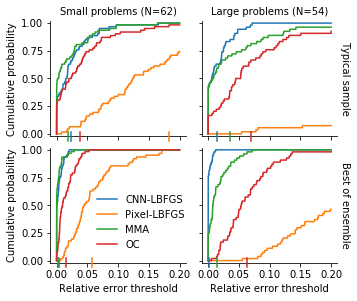

In [0]:
g = (
    cdf_array
    .to_dataframe()
    .reset_index()
    .pipe(seaborn.FacetGrid,
          col='large_problems', row='samples', hue='method_name',
          margin_titles=True, aspect=1.2, size=2)
    .map_dataframe(seaborn.lineplot, 'threshold', 'error')
)
for i in range(2):
  for j in range(2):
    for point in average_error[i, j].data.tolist():
      g.axes[i, j].plot([point, point], [-0.06, 0.02],
                        clip_on=(point > 0.2), zorder=10)

for ax in g.axes.flat:
    plt.setp(ax.texts, text="")
(g
    .set(xticks=[0, 0.05, 0.1, 0.15, 0.2], xlim=(-0.01, 0.21), ylim=(-0.02, 1.02))
    .set_xlabels('Relative error threshold')
    .set_ylabels('Cumulative probability')
    .set_titles(row_template='{row_name}', col_template='{col_name}')
)
g.axes[1, 0].legend(frameon=False, loc='lower left', bbox_to_anchor=(0.28, 0.04))
g.fig.subplots_adjust(left=0.13, right=0.96, bottom=0.1, top=0.94, wspace=0.12, hspace=0.1)
# g.fig.savefig('error-cdf-grid.pdf')

## Average relative error at step=1000

In [0]:
all_problem_results = xarray.concat(
    [typical_loss.sel(step=1000).mean('problem_name'),
     ensemble_loss.sel(step=1000).mean('problem_name')],
   dim=pandas.Index(['Typical sample', 'Best of ensemble'], name='samples')
).assign_coords(method_name=['CNN-LBFGS', 'Pixel-LBFGS', 'MMA', 'OC'])

average_error_all = xarray.concat([
    average_error,
    all_problem_results.expand_dims('large_problems').assign_coords(large_problems=['All problems (N=116)'])
], dim='large_problems')

In [0]:
average_error_all.stack(z=['samples', 'large_problems']).T.to_pandas().round(4)

method_name                             CNN-LBFGS  Pixel-LBFGS     MMA      OC
samples          large_problems                                               
Typical sample   Small problems (N=62)     0.0232       0.1832  0.0192  0.0385
                 Large problems (N=54)     0.0148       0.5481  0.0348  0.0700
                 All problems (N=116)      0.0193       0.3531  0.0265  0.0531
Best of ensemble Small problems (N=62)     0.0037       0.0580  0.0028  0.0149
                 Large problems (N=54)     0.0013       0.2233  0.0150  0.0632
                 All problems (N=116)      0.0026       0.1350  0.0084  0.0374

## Relative error over time

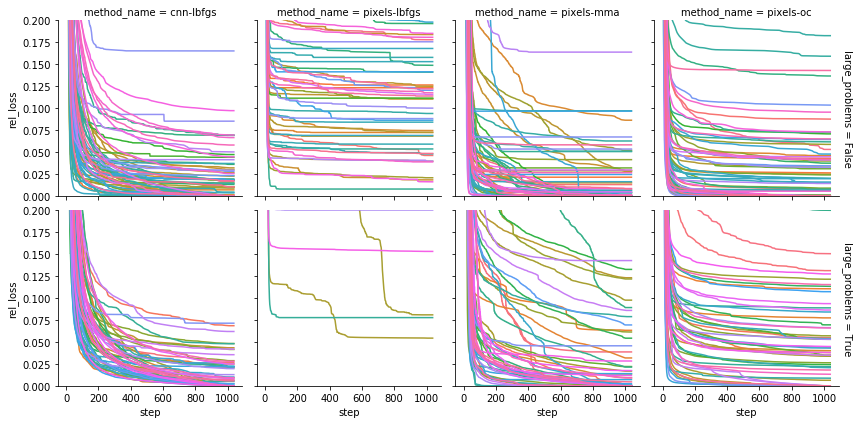

In [0]:
# typical examples
(typical_loss
 .assign_coords(large_problems=lambda x: x['size'] >= 128*256)
 .to_dataframe()
 .reset_index()
 .pipe(seaborn.FacetGrid, row='large_problems', col='method_name', hue='problem_name', margin_titles=True)
 .map(plt.plot, 'step', 'rel_loss')
 .set(ylim=(0, 0.2)))

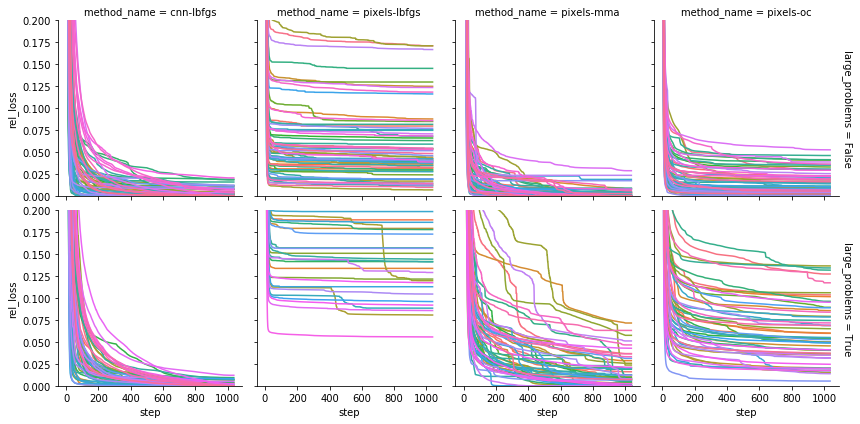

In [0]:
# best of ensemble
(ensemble_loss
 .assign_coords(large_problems=lambda x: x['size'] >= 128*256)
 .to_dataframe()
 .reset_index()
 .pipe(seaborn.FacetGrid, row='large_problems', col='method_name', hue='problem_name', margin_titles=True)
 .map(plt.plot, 'step', 'rel_loss')
 .set(ylim=(0, 0.2)))

## Fraction of designs with error below a threshold

In [0]:
t = [0.005, 0.01, 0.02, 0.05, 0.1]
error_threshold = xarray.DataArray(t, name='error_threshold', coords=[('error_threshold', t)])

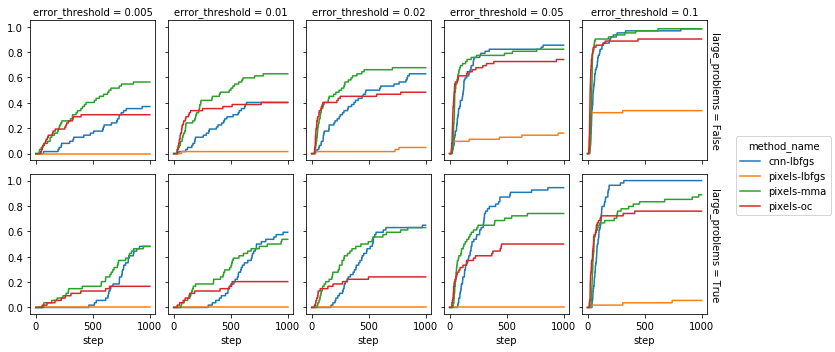

In [0]:
g = ((typical_loss < error_threshold)
 .sel(step=slice(1000))
 .assign_coords(large_problems=lambda x: x['size'] >= 128*256)
 .groupby('large_problems')
 .mean('problem_name')
 .plot.line(x='step', hue='method_name', col='error_threshold', row='large_problems', size=2.5, aspect=.75)
)
g.fig.subplots_adjust(wspace=0.1, right=0.85)

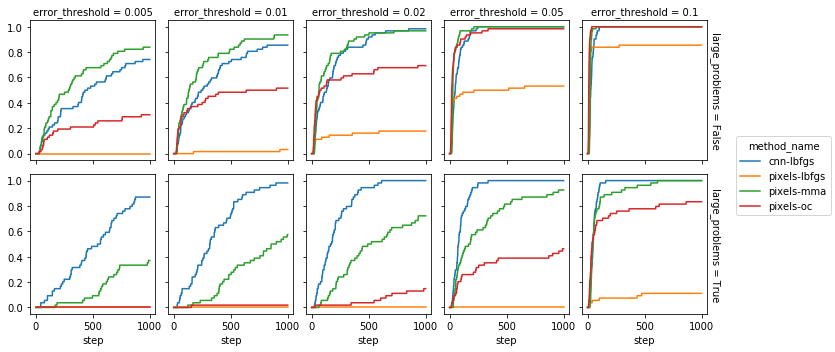

In [0]:
g = ((ensemble_loss < error_threshold)
 .sel(step=slice(1000))
 .assign_coords(large_problems=lambda x: x['size'] >= 128*256)
 .groupby('large_problems')
 .mean('problem_name')
 .plot.line(x='step', hue='method_name', col='error_threshold', row='large_problems', size=2.5, aspect=.75)
)
g.fig.subplots_adjust(wspace=0.1, right=0.85)

## Raw compliance numbers

This might be useful for benchmarking purposes, or testing a new code.

In [0]:
# "typical" results
(
    ds_typical
    .loss
    .sel(step=1000)
    .median('seed')
    .transpose('problem_name', 'method_name')
    .reindex(problem_name=list(problems.PROBLEMS_BY_NAME))
    .round(3)
    .to_pandas()
    .style.background_gradient('plasma_r', axis=1)
)

method_name,cnn-lbfgs,pixels-lbfgs,pixels-mma,pixels-oc
problem_name,,,,
mbb_beam_96x32_0.5,206.454,220.68,209.808,210.507
mbb_beam_192x64_0.4,241.499,278.451,242.926,245.053
mbb_beam_384x128_0.3,302.854,403.899,300.986,317.186
mbb_beam_192x32_0.5,1235.83,1339.73,1236.1,1243.56
mbb_beam_384x64_0.4,1397.8,1626.99,1392.94,1415.01
cantilever_beam_full_96x32_0.4,250.132,281.753,255.477,256.697
cantilever_beam_full_192x64_0.3,312.763,391.54,312.443,314.912
cantilever_beam_full_384x128_0.2,446.811,744.059,437.874,453.132
cantilever_beam_full_384x128_0.15,641.526,1187.5,600.418,633.383


In [0]:
# "best of ensemble" results
(
    ds_filtered
    .loss
    .sel(step=1000)
    .min('seed')
    .transpose('problem_name', 'method_name')
    .reindex(problem_name=list(problems.PROBLEMS_BY_NAME))
    .round(3)
    .to_pandas()
    .style.background_gradient('plasma_r', axis=1)
)

method_name,cnn-lbfgs,pixels-lbfgs,pixels-mma,pixels-oc
problem_name,,,,
mbb_beam_96x32_0.5,205.486,209.396,206.027,206.776
mbb_beam_192x64_0.4,237.864,250.719,238.619,239.652
mbb_beam_384x128_0.3,294.757,320.828,298.471,310.979
mbb_beam_192x32_0.5,1221.31,1255.03,1226.15,1225.87
mbb_beam_384x64_0.4,1375.28,1479.14,1381.2,1394.33
cantilever_beam_full_96x32_0.4,247.291,254.925,248.261,249.665
cantilever_beam_full_192x64_0.3,304.82,328.443,304.215,311.09
cantilever_beam_full_384x128_0.2,431.574,513.154,432.485,453.132
cantilever_beam_full_384x128_0.15,597.665,767.702,600.418,633.383
